In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


from sklearn.metrics import mean_squared_error

# Forecast with ARMA ARIMA and SARIMA models: An Initial Study

## Autoregressive Moving Average (ARMA)
The term “autoregressive” in ARMA means that the model uses past values to predict future ones. Specifically, predicted values are a weighted linear combination of past values. 

This type of regression method is similar to linear regression, with the difference being that the feature inputs here are historical values. 

Moving average refers to the predictions being represented by a weighted, linear combination of white noise terms, where white noise is a random signal. 

The idea here is that ARMA uses a combination of past values and white noise in order to predict future values. Autoregression models market participant behavior like buying and selling BTC, predicting temperature, stock prices, sales and many other types of data. 

The white noise models shock events like wars, recessions, holidays and political events. 

We can define an ARMA model using the SARIMAX package:

This model takes into account exogenous variables (exog), or in other words, use external data in our forecast

In [2]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

In [3]:
data.head()

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


In [4]:
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


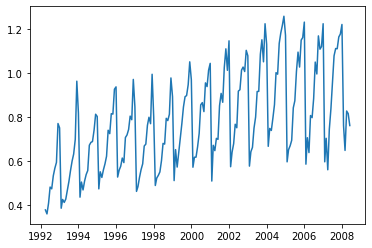

In [5]:
plt.plot(data.index, data.y)

We have a slightly increasing seasonal behavior of y values

start_date = 1992-04-01	
end_date = 2008-06-01

In [6]:
train = data[data.index < pd.to_datetime("2005-06-01", format='%Y-%m-%d')]
test = data[data.index >= pd.to_datetime("2005-06-01", format='%Y-%m-%d')]

exog_train = np.array(train['exog_1'])
exog_test = np.array(test['exog_1'])

train = train.drop(['exog_1', 'exog_2'], axis=1)
test = test.drop(['exog_1', 'exog_2'], axis=1)

In [7]:
print(len(train))
print(len(test))

158
37


In [8]:
print(len(exog_train))
print(len(exog_test))

158
37


Text(0.5, 1.0, 'Train/Test split for y Data')

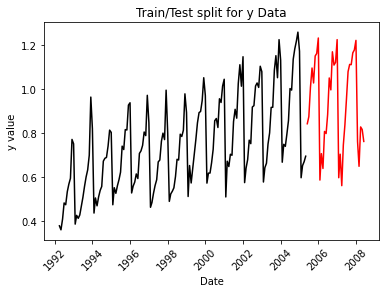

In [9]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('y value')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for y Data")

In [10]:
input_data = train['y']

To define an ARMA model with the SARIMAX class, we pass in the order parameters of (1, 0 ,1). Alpha corresponds to the significance level of our predictions. Typically, we choose an alpha = 0.05. Here, the ARIMA algorithm calculates upper and lower bounds around the prediction such that there is a 5 percent chance that the real value will be outside of the upper and lower bounds. This means that there is a 95 percent confidence that the real value will be between the upper and lower bounds of our predictions.

In [11]:
ARMAmodel = SARIMAX(input_data, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.89944D-01    |proj g|=  1.43904D-01

At iterate    5    f= -4.90102D-01    |proj g|=  5.57172D-02

At iterate   10    f= -4.90160D-01    |proj g|=  2.52410D-03

At iterate   15    f= -4.90170D-01    |proj g|=  3.82526D-02

At iterate   20    f= -4.90397D-01    |proj g|=  3.92482D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   1.545D-04  -4.904D-01
  F = -0.49041075541585433     

CONVERG

 This problem is unconstrained.


In [12]:
y_pred = ARMAmodel.get_forecast(len(test.index), exog=exog_test)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
arma_pred = y_pred_df["Predictions"] 

In [13]:
arma_rmse = np.sqrt(mean_squared_error(test["y"].values, arma_pred))
print("RMSE: ",arma_rmse)

RMSE:  0.4837750522458876


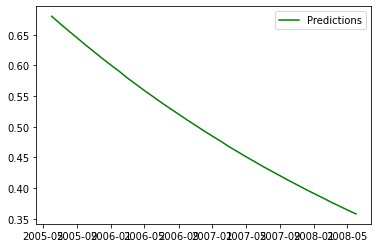

In [14]:
plt.plot(arma_pred, color='green', label = 'Predictions')
plt.legend()

# ARIMA (Auto-Regressive Integrated Moving Average)
An ARIMA task has three parameters. The first parameter corresponds to the lagging (past values), the second corresponds to differencing (this is what makes non-stationary data stationary), and the last parameter corresponds to the white noise (for modeling shock events). 

The ARIMA model is an ARMA model yet with a preprocessing step included in the model that we represent using I(d). I(d) is the difference order, which is the number of transformations needed to make the data stationary. **So, an ARIMA model is simply an ARMA model on the differenced time series.**

In [15]:
ARIMAmodel = ARIMA(input_data, order = (20, 1, 0))
ARIMAmodel = ARIMAmodel.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


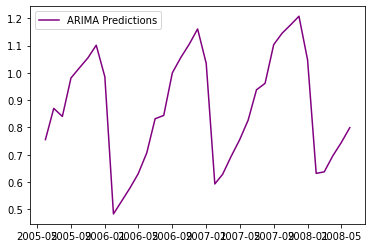

In [16]:
y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
arima_pred = y_pred_df["Predictions"] 
plt.plot(arima_pred, color='purple', label = 'ARIMA Predictions')
plt.legend()

In [17]:
arima_rmse = np.sqrt(mean_squared_error(test["y"].values, arima_pred))
print("RMSE: ",arima_rmse)

RMSE:  0.10564371974084978


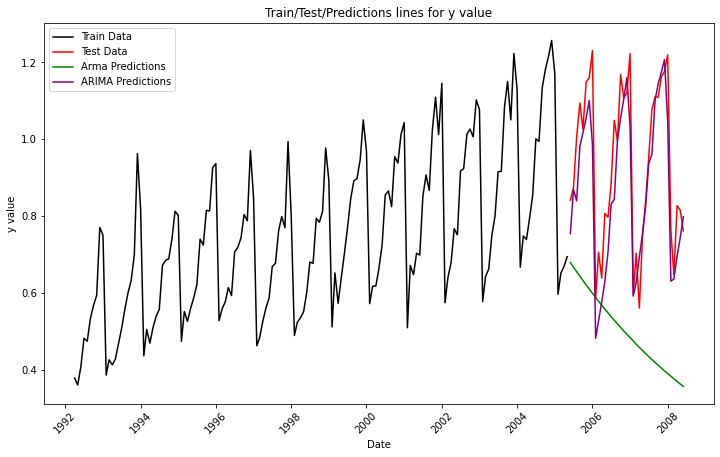

In [18]:
plt.figure(figsize=(12,7))
plt.plot(train, color = "black", label = 'Train Data')
plt.plot(test, color = "red", label = 'Test Data')
plt.plot(arma_pred, color='green', label = 'Arma Predictions')
plt.plot(arima_pred, color='purple', label = 'ARIMA Predictions')
plt.ylabel('y value')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test/Predictions lines for y value")
plt.legend()
plt.show()

ARIMA as its name suggests, it supports both an autoregressive and moving average elements. The integrated element refers to differencing allowing the method to support time series data with a trend.

A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle.

ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

# SARIMA (Seasonal Auto-Regressive Integrated Moving Average)

The ARIMA model is great, but to include seasonality and exogenous variables in the model can be extremely powerful. Since the ARIMA model assumes that the time series is stationary, we need to use a different model.

Seasonal ARIMA captures historical values, shock events and seasonality. We can define a SARIMA model using the SARIMAX class:

#### Order

p: Trend autoregression order.

d: Trend difference order.

q: Trend moving average order.

In [19]:
SARIMAXmodel = SARIMAX(input_data, order = (20, 1, 1)) # order(p, d, q)
SARIMAXmodel = SARIMAXmodel.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72991D+00    |proj g|=  1.74886D+02
  ys=-2.291E-01  -gs= 8.331E-01 BFGS update SKIPPED

At iterate    5    f= -6.13792D-01    |proj g|=  1.15664D+00

At iterate   10    f= -1.28265D+00    |proj g|=  2.80691D+00

At iterate   15    f= -1.39638D+00    |proj g|=  3.68774D-01

At iterate   20    f= -1.43961D+00    |proj g|=  2.91949D-01

At iterate   25    f= -1.45910D+00    |proj g|=  1.33397D-01

At iterate   30    f= -1.46506D+00    |proj g|=  9.39739D-02

At iterate   35    f= -1.48028D+00    |proj g|=  4.32021D-01

At iterate   40    f= -1.48384D+00    |proj g|=  1.28206D-01

At iterate   45    f= -1.49308D+00    |proj g|=  2.65913D-01


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f= -1.49674D+00    |proj g|=  3.28264D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     67      1     1     0   3.283D-01  -1.497D+00
  F =  -1.4967355344290483     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


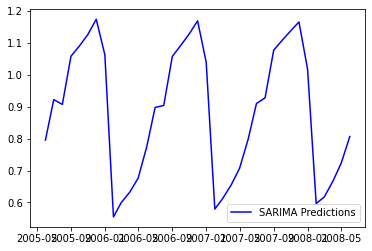

In [20]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
sarima_pred = y_pred_df["Predictions"] 
plt.plot(sarima_pred, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [22]:
sarima_rmse = np.sqrt(mean_squared_error(test["y"].values, sarima_pred))
print("RMSE: ",sarima_rmse)

RMSE:  0.0899426507356419


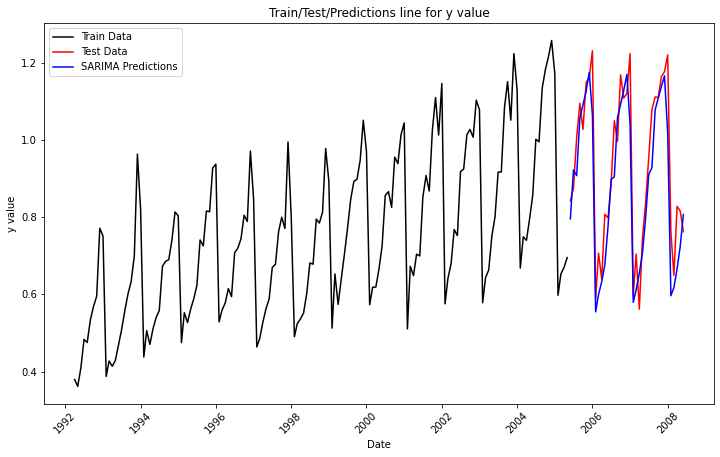

In [21]:
plt.figure(figsize=(12,7))
plt.plot(train, color = "black", label = 'Train Data')
plt.plot(test, color = "red", label = 'Test Data')
plt.plot(sarima_pred, color='blue', label = 'SARIMA Predictions')
plt.ylabel('y value')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test/Predictions line for y value")
plt.legend()
plt.show()

# Final Result

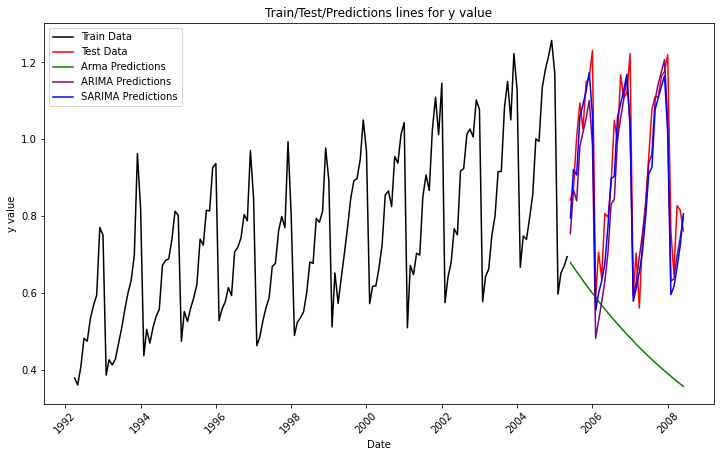

In [23]:
plt.figure(figsize=(12,7))
plt.plot(train, color = "black", label = 'Train Data')
plt.plot(test, color = "red", label = 'Test Data')
plt.plot(arma_pred, color='green', label = 'Arma Predictions')
plt.plot(arima_pred, color='purple', label = 'ARIMA Predictions')
plt.plot(sarima_pred, color='blue', label = 'SARIMA Predictions')
plt.ylabel('y value')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test/Predictions lines for y value")
plt.legend()
plt.show()

# Applying our Sarima Model in Future Data

In [25]:
start = '2008-06-01'
end = '2009-06-01'

yhat_arima = ARIMAmodel.predict(start=start, end=end)
yhat_sarima = SARIMAXmodel.predict(start=start, end=end)

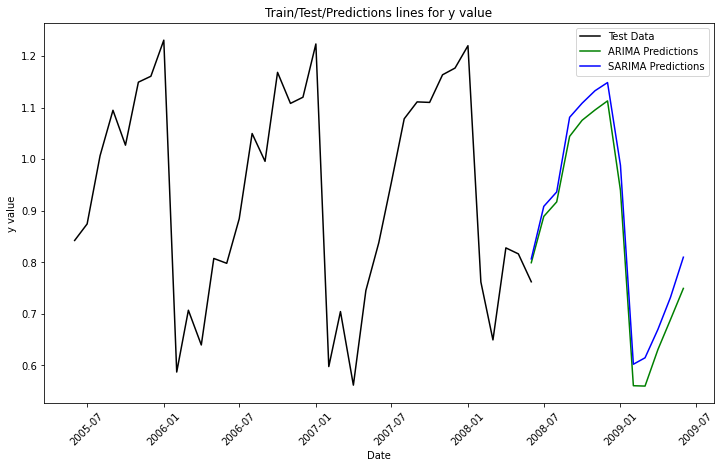

In [26]:
plt.figure(figsize=(12,7))
plt.plot(test, color = "black", label = 'Test Data')
plt.plot(yhat_arima, color='green', label = 'ARIMA Predictions')
plt.plot(yhat_sarima, color='blue', label = 'SARIMA Predictions')
plt.ylabel('y value')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test/Predictions lines for y value")
plt.legend()
plt.show()